# Criando Chatbots para FAQS com LLMs e Embeddings usando Langchain

# Índice
1. [Introdução](#introduction)
2. [Motivação](#motivation)
    1. [Como ensinar conhecimento ao GPT?](#how-to-teach)
    2. [Overview do Chatbot](#overview)
3. [Search](#search-approach)
    1. [Como encontrar documentos relevantes para a pergunta?](#how-to-find) 
    2. [Tokenization](#tokens)
    3. [Bag of Words (BOW) e Vocabulary](#bow)
    4. [Vetorizando frases](#vector-phrases)
    5. [Distância entre vetores](#vector-dist)
    6. [Embeddings](#embeds)
    7. [Vector Stores](#chroma)
3. [Ask](#ask)
    1. [Prompt Template](#prompt-template)
    2. [Chains](#chains)
    3. [Ask GPT!](#ask-gpt)

## 1. Introdução <a name="introduction"></a>

Como ensinar o chatGPT a responder sobre assuntos que ele não conhece? Se você já usou algum LLM (Large Language Models) como o chatGPT, viu que são ótimos em responder perguntas, mas só se forem tópicos relativamente abundantes e públicos na internet. Neste tutorial, vamos entender na prática como criar soluções com LLM capazes de responder tópicos muito específicos, alimentando a IA Generativa com mais informações, como dúvidas comuns da sua empresa (FAQs) ou eventos recentes que não estão no período treinamento do LLM. 

Para isso, vamos usar Embeddings e um framework bem ativo na comunidade, o [Langchain](https://github.com/langchain-ai/langchain), e vamos focar no uso do GPT como LLM (embora vários outros possam ser usados para o mesmo propósito) para a tarefa de responder perguntas frequentes de uma empresa como a [Buser](https://www.buser.com.br/sobre).

Para começar, siga as instruções do `README.md` para garantir as dependências (de preferência em um ambiente virtual).

## 2. Motivação <a name="motivation"></a>

Como o GPT se comporta com perguntas sobre esses temas? Por exemplo:
- As eleições presidenciais no Brasil?
- Perguntas Frequentes (FAQs) de uma empresa
- Informações de conversas anteriores

<div>
<img src="images/01_eleicoes2022.png" width="600"/>
</div>

<div>
<img src="images/02_buser.png" width="600"/>
</div>

### Overview  do Chatbot <a name="overview"></a>

<div>
<img src="images/03_overview.jpeg" width="900"/>
</div>

### Como ensinar conhecimento ao GPT? <a name="how-to-teach"></a>

É bem claro que falta __contexto__ para o GPT dar uma resposta boa e factual (muitas vezes ele pode "alucinar" e criar respostas irreais na tentativa de responder algo). O GPT (assim como outros LLMs) pode aprender mais conhecimento por duas vias:

1. Atualizando os pesos/parâmetros da sua arquitetura (treino e fine-tuning).
2. Inserindo contexto diretamente na pergunta (prompt).

Ao tentar resolver o problema, é bastante natural pensar logo na primeira alternativa. Mas ela só é recomendada pela OpenAI para tarefas bem específicas e estilos; no caso da tarefa de dar uma resposta factual, será mais difícil para o modelo lembrar com precisão os assuntos ensinados, ainda mais comparado ao tanto de conhecimento que ele tem treinado. __Funciona como uma memória de longo prazo para uma prova: você não tem tanta assertividade ao recordar assuntos na hora da prova__.

No segundo caso, inserir contexto no prompt é como uma __"memória de curto prazo": é como fazer uma prova "colando" do livro, pois o modelo tem acesso claro ao contexto necessário para responder especificamente sua pergunta__. 

Porém, os modelos oferecidos pela OpenAI têm limites de contexto (prompt + completion):

| Model           | Maximum text length       |
|-----------------|---------------------------|
| `gpt-3.5-turbo` | 4,096 tokens (~5 pages)   |
| `gpt-3.5-turbo-16k` | 16,385 tokens (~20 pages)   |	
| `gpt-4`         | 8,192 tokens (~10 pages)  |
| `gpt-4-32k`     | 32,768 tokens (~40 pages) |

Como inserir o contexto necessário no input do modelo? Essa é a estratégia chamada Search-Ask, onde seguimos duas ideias básicas: 

1. __Search__: buscar em uma base de conhecimento por seções de texto (documents) que sejam úteis para responder a pergunta
2. __Ask__: inserir os documentos relevantes na pergunta original e fazer a pergunta ao GPT.

Na prática, isso equivale a construir um bom prompt, ou seja, é uma forma de praticar __Prompt Engineering__. 

O primeiro passo é aprender sobre a etapa `Search`, que envolve entender mais sobre: como transformar texto em números; o que são tokens e o que são embeddings.


<font size="2">_obs: a resposta da 1ª pergunta, sobre eleições, pode ser feita com GPT-4 e plugin para o Bing (que no fim das contas acaba usando a mesma ideia de inserir contexto na pergunta para o GPT)_. A resposta da 3ª também usa a mesma ideia, pois na interface do chatGPT ele está inserindo as conversas anteriores como contexto para o GPT.
</font>

## Search <a name="search-approach"></a>

### Como encontrar documentos relevantes para a pergunta? <a name="how-to-find"></a>

A fase de busca é muito importante para o nosso problema, pois caso coloquemos documentos com pouca relação com a pergunta no prompt para o GPT, o GPT não irá conseguir produzir uma boa resposta. Existem diversas estratégias para fazer essa busca de documentos, mas a ideia básica por trás é que queremos __buscar documentos que tenham similaridade contextual com a pergunta__ .

Uma forma clássica de comparar textos entre si é usar __Embeddings__, que "nada mais" são representações númericas de palavras ou frases, tipicamente representações vetoriais em um espaço vetorial, de tal forma que vetores próximos entre si (matematicamente) implicam frases ou palavras similares, ou seja, a distância entre vetores mede o grau de similaridade entre eles. 

Antes de prosseguir, vamos entender mais de perto como os embeddings funcionam e, para entendê-los, precisamos primeiro aprender sobre __Tokenizers__ e __Bag of Words__. 

### Tokenization <a name="tokens"></a>

Tokenization é um passo crucial em muitos processos de Processamento de Linguagem Natural (NLP), e aqui não é diferente. É a tarefa de segmentar texto em partes menores, conhecidas como __tokens__, que podem ser palavras, subpalavras ou caracteres. Isso facilita o tratamento do texto por modelos e algoritmos de NLP, __afinal modelos não sabem ler, só sabem trabalhar com números rsrs__. 

Vamos explorar o processo de tokenização em um nível básico, para aquecer.

In [1]:
def simple_whitespace_tokenizer(text: str) -> list:
    """
    Tokeniza o texto usando espaços em branco como delimitadores.
    """
    return text.split()

In [2]:
text = """ 
Eu adoro participar da Python Brasil. 
Ano passado fui na Python Brasil em Manaus e agora estou na edição 2023, em Caxias do Sul
"""

tokens = simple_whitespace_tokenizer(text)
print(tokens)

['Eu', 'adoro', 'participar', 'da', 'Python', 'Brasil.', 'Ano', 'passado', 'fui', 'na', 'Python', 'Brasil', 'em', 'Manaus', 'e', 'agora', 'estou', 'na', 'edição', '2023,', 'em', 'Caxias', 'do', 'Sul']


Podemos tokenizar com diferentes estratégias:

In [3]:
import string

def punctuation_based_tokenizer(text: str) -> list:
    """
    Tokeniza o texto usando espaços em branco e pontuação como delimitadores.
    """
    for punct in string.punctuation:
        text = text.replace(punct, f' {punct} ')
    return text.split()

tokens = punctuation_based_tokenizer(text)
print(tokens)

['Eu', 'adoro', 'participar', 'da', 'Python', 'Brasil', '.', 'Ano', 'passado', 'fui', 'na', 'Python', 'Brasil', 'em', 'Manaus', 'e', 'agora', 'estou', 'na', 'edição', '2023', ',', 'em', 'Caxias', 'do', 'Sul']


Usando regex:

In [4]:
import re

def regex_tokenizer(text: str) -> list:
    """
    Tokeniza o texto usando expressões regulares para identificar padrões de tokens.
    (para ver melhor regex na prática: https://regex101.com/)
    """
    return re.findall(r'\b\w+\b', text)


tokens = regex_tokenizer(text)
print(tokens)

['Eu', 'adoro', 'participar', 'da', 'Python', 'Brasil', 'Ano', 'passado', 'fui', 'na', 'Python', 'Brasil', 'em', 'Manaus', 'e', 'agora', 'estou', 'na', 'edição', '2023', 'em', 'Caxias', 'do', 'Sul']


Legal, temos uma primeira forma de transformar textos (linguagem) em números! Mas, se para cada frase fizemos uma lista como essas acima, será difícil comparar frases entre si, devido a diferença de tamanho, quantidade de palavras novas que irão surgir...precisamos de alguma abordagem mais robusta para atacar esse problema.

### Bag of Words (BOW) e Vocabulary: <a name="bow"></a>

__Bag of Words (BOW)_ é um nome bonito para uma tradução literal bem clara: "saco de palavras"__. É uma forma de __converter texto em números de forma mais padronizada__, e que permite comparar melhor frases e até alimentar modelos de aprendizado de máquina. 

A ideia por trás é simples: imagine que possamos construir um vocabulário de $N$ tokens, e que eles aproximem bem toda a linguagem possível de ser escrita, na esperança de representar bem a linguagem. Com isso, podemos montar um __vocabulário para a a linguagem, uma lista de palavras/tokens únicos__. Então, para qualquer frase, poderemos criar um vetor de tamanho $N$ (padronizado), onde __cada posição representa um palavra/token do vocabulário__, e então para cada posição podemos colocar o número de vezes que aquele token apareceu na nossa frase.


Para montar o vocabulário, precisamos de uma boa quantidade de textos que representem a linguagem. o mais diverso possível. O vocabulário é simplesmente um conjunto de todas as palavras ou tokens únicos presentes no conjunto de textos (geralmente chamado de _corpus_ ou _corpora_).

In [5]:
def build_vocabulary(texts: list) -> dict:
    """
    Constrói um vocabulário a partir de uma lista de textos.
    """
    vocabulary = {}
    for text in texts:
        for word in text.split():
            vocabulary[word] = vocabulary.get(word, 0) + 1
    return vocabulary

Vamos usar um exemplos simples relacionados à Python Brasil. Note a frequência de termos meio irrelevantes para contexto, como preposições, advérbios e artigos. Em processamentos mais avançados de texto, é comum remover esses termos muito frequentes, pois eles deixam o vocabulário muito maior mas sem adicionar informação relevante ao contexto.

<font size="2">_obs: sim, eu criei esses exemplos dando um exemplo ao GPT e pedindo vários outros rs._
</font>

In [6]:
from pprint import pprint

corpus_pybr23 = [
    "Eu adoro participar da Python Brasil.",
    "Ano passado fui na Python Brasil em Manaus e agora estou na edição 2023, em Caxias do Sul.",
    "Estou ansioso para os workshops na Python Brasil este ano.",
    "A comunidade na Python Brasil é sempre muito acolhedora.",
    "A Python Brasil é o evento perfeito para aprender novas técnicas de programação.",
    "É incrível ver tantas pessoas apaixonadas por Python na Python Brasil.",
    "Os palestrantes da Python Brasil sempre trazem perspectivas novas e interessantes.",
    "Conheci muitos dos meus colegas de profissão na Python Brasil.",
    "A programação da Python Brasil deste ano está imperdível.",
    "As discussões na Python Brasil sempre me deixam inspirado para novos projetos."
    "Os tutoriais na Python Brasil são sempre muito elucidativos.",
    "A Python Brasil é uma ótima oportunidade para conhecer os líderes da comunidade Python.",
    "Estou contando os dias para a Python Brasil.",
    "A Python Brasil é o lugar onde sempre encontro as últimas novidades em Python.",
    "A interação com outros desenvolvedores na Python Brasil é sempre muito valiosa.",
    "Os keynotes da Python Brasil são sempre muito inspiradores.",
    "A Python Brasil sempre traz palestrantes de renome.",
    "Estou empolgado para apresentar meu projeto na Python Brasil este ano.",
    "A Python Brasil é uma experiência de aprendizado imersiva.",
    "A feira de empregos da Python Brasil é uma ótima chance para encontrar novas oportunidades."
]

vocabulary = build_vocabulary(corpus_pybr23)
pprint(vocabulary)

{'2023,': 1,
 'A': 9,
 'Ano': 1,
 'As': 1,
 'Brasil': 16,
 'Brasil.': 4,
 'Caxias': 1,
 'Conheci': 1,
 'Estou': 3,
 'Eu': 1,
 'Manaus': 1,
 'Os': 2,
 'Python': 21,
 'Python.': 2,
 'Sul.': 1,
 'a': 1,
 'acolhedora.': 1,
 'adoro': 1,
 'agora': 1,
 'ano': 1,
 'ano.': 2,
 'ansioso': 1,
 'apaixonadas': 1,
 'aprender': 1,
 'aprendizado': 1,
 'apresentar': 1,
 'as': 1,
 'chance': 1,
 'colegas': 1,
 'com': 1,
 'comunidade': 2,
 'conhecer': 1,
 'contando': 1,
 'da': 6,
 'de': 5,
 'deixam': 1,
 'desenvolvedores': 1,
 'deste': 1,
 'dias': 1,
 'discussões': 1,
 'do': 1,
 'dos': 1,
 'e': 2,
 'edição': 1,
 'elucidativos.': 1,
 'em': 3,
 'empolgado': 1,
 'empregos': 1,
 'encontrar': 1,
 'encontro': 1,
 'este': 2,
 'estou': 1,
 'está': 1,
 'evento': 1,
 'experiência': 1,
 'feira': 1,
 'fui': 1,
 'imersiva.': 1,
 'imperdível.': 1,
 'incrível': 1,
 'inspirado': 1,
 'inspiradores.': 1,
 'interação': 1,
 'interessantes.': 1,
 'keynotes': 1,
 'lugar': 1,
 'líderes': 1,
 'me': 1,
 'meu': 1,
 'meus': 1,
 'mu

## Vetorizando frases <a name="vector-phrases"></a>

Uma vez que criamos um vocabulário, podemos "vetorizar" frases: cada frase será representada por um vetor do mesmo tamanho do vocabulário, onde cada entrada do vetor será o número de vezes que o token apareceu na frase. Para manter um mesmo padrão, é preciso usar o mesmo tokenizador tanto na construção do vocubulário como na hora de vetorizar uma frase. Por exemplo: não faz sentido considerar pontuações no vocabulário e não considerá-las na hora de vetorizar uma frase, certo?

Vamos atualizar nossa construção de vocabulário:

In [7]:
def build_vocabulary(texts: list, tokenizer: callable) -> dict:
    """
    Constrói um vocabulário a partir de uma lista de textos, usando uma função de tokenização fornecida.
    
    Args:
    texts (list): Uma lista de textos a partir dos quais construir o vocabulário.
    tokenizer (callable): A função de tokenização a ser utilizada.
    
    Returns:
    dict: Um dicionário representando o vocabulário, onde as chaves são as palavras e os valores são as contagens.
    """
    vocabulary = {}
    for text in texts:
        for token in tokenizer(text):
            vocabulary[token] = vocabulary.get(token, 0) + 1
    return vocabulary

vocabulary = build_vocabulary(corpus_pybr23, regex_tokenizer)
pprint(vocabulary)

{'2023': 1,
 'A': 9,
 'Ano': 1,
 'As': 1,
 'Brasil': 20,
 'Caxias': 1,
 'Conheci': 1,
 'Estou': 3,
 'Eu': 1,
 'Manaus': 1,
 'Os': 3,
 'Python': 23,
 'Sul': 1,
 'a': 1,
 'acolhedora': 1,
 'adoro': 1,
 'agora': 1,
 'ano': 3,
 'ansioso': 1,
 'apaixonadas': 1,
 'aprender': 1,
 'aprendizado': 1,
 'apresentar': 1,
 'as': 1,
 'chance': 1,
 'colegas': 1,
 'com': 1,
 'comunidade': 2,
 'conhecer': 1,
 'contando': 1,
 'da': 6,
 'de': 5,
 'deixam': 1,
 'desenvolvedores': 1,
 'deste': 1,
 'dias': 1,
 'discussões': 1,
 'do': 1,
 'dos': 1,
 'e': 2,
 'edição': 1,
 'elucidativos': 1,
 'em': 3,
 'empolgado': 1,
 'empregos': 1,
 'encontrar': 1,
 'encontro': 1,
 'este': 2,
 'estou': 1,
 'está': 1,
 'evento': 1,
 'experiência': 1,
 'feira': 1,
 'fui': 1,
 'imersiva': 1,
 'imperdível': 1,
 'incrível': 1,
 'inspirado': 1,
 'inspiradores': 1,
 'interação': 1,
 'interessantes': 1,
 'keynotes': 1,
 'lugar': 1,
 'líderes': 1,
 'me': 1,
 'meu': 1,
 'meus': 1,
 'muito': 4,
 'muitos': 1,
 'na': 10,
 'novas': 3,
 'n

Agora podemos vetorizar frases:

In [8]:
def vectorize(text: str, vocabulary: dict) -> list:
    """
    Vetoriza um texto com base em um vocabulário fornecido.
    """
    vector = [0] * len(vocabulary)
    word_list = text.split()
    for i, word in enumerate(vocabulary):
        vector[i] = word_list.count(word)
    return vector

In [9]:
vectorized_sentences = [vectorize(sentence, vocabulary) for sentence in corpus_pybr23]

len(corpus_pybr23), len(vectorized_sentences)

(19, 19)

Vamos ver alguns exemplos:

In [10]:
import matplotlib.pyplot as plt

def show_vector(i, vectors, corpus):
    print("Tamanho do vocabulário: ", len(vocabulary), " tokens")
    print(f"Frase para vetorizar: '{corpus[i]}'")
    print("Tamanho da frase vetorizada: ", len(vectors[i]))
    print("Primeiros 20 elementos da frase vetorizada", vectors[i][:20])

In [11]:
# experimente outras mensagens mudando o index i
show_vector(i=0, vectors=vectorized_sentences, corpus=corpus_pybr23)

Tamanho do vocabulário:  107  tokens
Frase para vetorizar: 'Eu adoro participar da Python Brasil.'
Tamanho da frase vetorizada:  107
Primeiros 20 elementos da frase vetorizada [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
show_vector(i=1, vectors=vectorized_sentences, corpus=corpus_pybr23)

Tamanho do vocabulário:  107  tokens
Frase para vetorizar: 'Ano passado fui na Python Brasil em Manaus e agora estou na edição 2023, em Caxias do Sul.'
Tamanho da frase vetorizada:  107
Primeiros 20 elementos da frase vetorizada [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0]


Note que os vetores tem um número grande de entradas, então não podemos visualizar facilmente eles em 2D. Mas vamos ver alguns exemplos em 2D logo a seguir!

### Distância entre vetores <a name="vector-dist"></a>

Agora que sabemos transformar frases em vetores, podemos calcualar distância entre frases! Basta definir alguma medida de distância numérica entre os vetores, agora numéricos. Existem várias formas de medir isso, então aqui vão algumas medidas clássicas:

- [Similaridade por Distância Euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance): 
$$d(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{i=1}^n (a_i - b_i)^2}$$ 
É uma medida da distância geométrica entre dois pontos (ou vetores) em um espaço n-dimensional, similar ao caso bi-dimensional, onde usamos os Teorema de Pitágoras.
- [Similaridade por Cosseno](https://en.wikipedia.org/wiki/Cosine_similarity) $$ \text{sim}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}|| \cdot ||\mathbf{b}||} $$
A similaridade do cosseno mede o cosseno do ângulo entre dois vetores não-nulos no espaço n-dimensional. Ela varia entre -1 e 1, onde 1 indica que os vetores são idênticos, 0 indica que os vetores são ortogonais (sem semelhança) e -1 indica que os vetores são diametralmente opostos.

A similaridade por cosseno é mais comum em aplicações com NLP do que a euclidiana, por diversos motivos. Note que ela se importa mais com a orientação dos vetores do que com os valores de cada componente. Ou seja, dois documentos que são do mesmo contexto, mas um sendo muito mais longo que o outro, terão orientação similar, mas uma distância euclidiana muito grande. Veremos exemplos em breve.

Vamos começar com exemplos mais simples. 

Já existe uma implementação pronta da [distância euclidiana na biblioteca scipy](https://www.google.com/search?q=from+scipy.spatial.distance+import+euclidean&oq=from+scipy.spatial.distance+import+euclidean&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBBzEzN2owajeoAgCwAgA&sourceid=chrome&ie=UTF-8) e da [similaridade por cosseno no no sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), por meio dos imports
```
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
```
mas, como exercício, deixaremos a implementação delas por completo aqui e mostraremos as duas.

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def manual_euclidean(vector1: np.array, vector2: np.array) -> float:
    """
    Calcula a distância euclidiana entre dois vetores.

    Args:
    vector1 (np.array): O primeiro vetor.
    vector2 (np.array): O segundo vetor.
    
    Returns:
    float: A distância euclidiana entre os vetores.
    """
    return np.sqrt(np.sum((vector1 - vector2)**2))

def manual_cosine_similarity(vector1: np.array, vector2: np.array) -> float:
    """
    Calcula a similaridade de cosseno entre dois vetores.

    Args:
    vector1 (np.array): O primeiro vetor.
    vector2 (np.array): O segundo vetor.
    
    Returns:
    float: A similaridade de cosseno entre os vetores.
    """
    dot_product = np.dot(vector1, vector2)
    magnitude_vector1 = np.sqrt(np.sum(vector1**2))
    magnitude_vector2 = np.sqrt(np.sum(vector2**2))
    return dot_product / (magnitude_vector1 * magnitude_vector2)

In [14]:
# Definindo alguns vetores. 
# Imagine que cada entrada representa um token do vocabulário de tamanho 2.
# a e b são mais próximos entre si do que c

a = np.array([2, 3])
b = np.array([3, 3])
c = np.array([7, 1])

# euclidiana
dist_ab = euclidean(a, b)
dist_ac = euclidean(a, c)
dist_bc = euclidean(b, c)

(dist_ab, dist_ac, dist_bc)

(1.0, 5.385164807134504, 4.47213595499958)

In [15]:
assert (dist_ab, dist_ac, dist_bc) == (manual_euclidean(a, b), manual_euclidean(a, c), manual_euclidean(b, c))

In [16]:
# similaridade de cosseno
# A função cosine_similarity retorna uma matriz, então nós pegamos o valor [0][0]
cos_sim_ab = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]
cos_sim_ac = cosine_similarity(a.reshape(1, -1), c.reshape(1, -1))[0][0]
cos_sim_bc = cosine_similarity(b.reshape(1, -1), c.reshape(1, -1))[0][0]

(cos_sim_ab, cos_sim_ac, cos_sim_bc)

(0.9805806756909202, 0.6667948594698258, 0.7999999999999999)

Para comparar as implementações, neste caso podem ocorrer pequenas variações númericas versus a implementação do sklearn (se quiser, veja o código fonte [aqui](https://github.com/scikit-learn/scikit-learn/blob/093e0cf14/sklearn/metrics/pairwise.py#L1534)), por isso vamos comparar de forma aproximada:

In [17]:
np.testing.assert_approx_equal(cos_sim_ab, manual_cosine_similarity(a, b))

In [18]:
np.testing.assert_approx_equal(cos_sim_ac, manual_cosine_similarity(a, c))

In [19]:
np.testing.assert_approx_equal(cos_sim_bc, manual_cosine_similarity(b, c))

#### Plotando os vetores

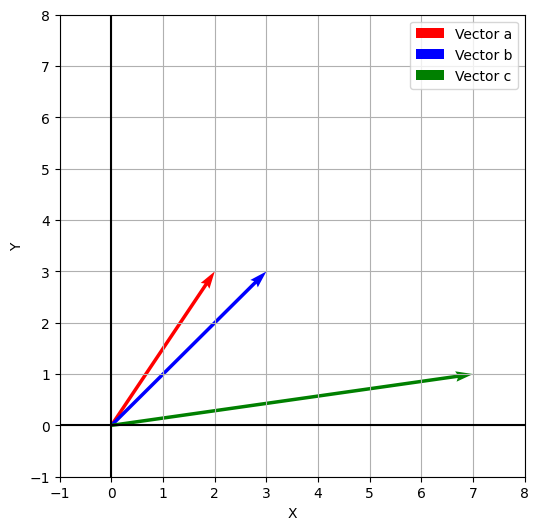

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.quiver(0, 0, a[0], a[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector a')
plt.quiver(0, 0, b[0], b[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector b')
plt.quiver(0, 0, c[0], c[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vector c')
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.legend()
plt.ylabel("Y")
plt.xlabel("X")


plt.show()

### Embeddings <a name="embeds"></a>

Deu para notar nos exemplos acima que os vocabulários podem ficar bem grandes, mesmo ao tentar excluir palavras que não adicionam muita informação semântica ao contexto, principalmente quando queremos comparar palavras e frases. Isso deixa os vetores esparsos (cheios de zeros) e mais difíceis de manipular. __Além disso, Bag of Words não conseguem capturar bem a relação entre palavras__. 

Para superar essas dificuldades, uma abordagem que fez e ainda faz sucesso é usar modelos de ML para aprender representações latentes da linguagem, capturando features semânticas no treinamento. Por "latente", queremos dizer que são features que não têm um significado facilmente interpretável como um token (ex: "Caxias") mas, quando bem treinadas, conseguem capturar nuances mais profundas como a ideia de uma frase estar falando de cidades, por exemplo.

Tecnicamente, __embbedings são representações densas e contínuas de palavras em um espaço vetorial de dimensão menor__ em comparação com as representações esparças como Bag of Words. Eles são muito usados em modelos e algoritmos de NLP.

Existem diversos modelos de embeddings por aí, sendo alguns dos mais famosos e pioneiros o [Word2Vec do Google](https://en.wikipedia.org/wiki/Word2vec), o [Glove](https://en.wikipedia.org/wiki/GloVe) (feito em Stanford), o [FastText](https://en.wikipedia.org/wiki/FastText) do Facebook e o [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) do Google. 

Mas tá faltando os embeddings de alguém né? Sim, a OpenAI oferece também um [serviço de embeddings](https://platform.openai.com/docs/guides/embeddings) próprio, e vamos focar nele neste tutorial. 

Para usar a API do GPT, vamos precisar de uma chave de API. Exporte essa chave para a variável de ambiente `OPENAI_API_KEY`.

In [21]:
import openai

def get_embedding(text: str):
    return np.array(
        openai.Embedding.create(
            input=text, model="text-embedding-ada-002"
        )["data"][0]["embedding"]
    )

In [22]:
caxias_do_sul = get_embedding("Caxias do Sul")

print("Tamanho do vetor: ", len(caxias_do_sul))
caxias_do_sul[:10]

Tamanho do vetor:  1536


array([ 0.00528153,  0.02633783,  0.01267034, -0.01246427, -0.04278402,
        0.03555142, -0.01505019, -0.0115469 ,  0.02019544, -0.02382503])

In [23]:
# Vamos comparar com outros termos

rio_grande_do_sul = get_embedding("Rio Grande do Sul")
belem = get_embedding("Belém")
para = get_embedding("Pará")

texas = get_embedding("Texas, USA")
apple = get_embedding("Apple Juice")

"Caxias do Sul" deve estar mais próximo de "Rio Grande do Sul" do que do "Pará": 

__Euclidian__

In [24]:
euclidean(caxias_do_sul, rio_grande_do_sul)

0.43859583916458317

In [25]:
euclidean(caxias_do_sul, para)

0.6013288503699833

In [26]:
euclidean(caxias_do_sul, texas)

0.6541827625926767

In [27]:
euclidean(caxias_do_sul, apple)

0.7207048688440133

__Cosine Similarity__

In [28]:
cosine_similarity(caxias_do_sul.reshape(1,-1), rio_grande_do_sul.reshape(1, -1))[0][0]

0.9038168412414286

In [29]:
cosine_similarity(caxias_do_sul.reshape(1,-1), para.reshape(1, -1))[0][0]

0.8192018001798618

In [30]:
cosine_similarity(caxias_do_sul.reshape(1,-1), texas.reshape(1, -1))[0][0]

0.7860224562623284

In [31]:
cosine_similarity(caxias_do_sul.reshape(1,-1), apple.reshape(1, -1))[0][0]

0.7402922003635106

Pronto, já sabemos transformar textos em vetores com embeddings poderosos! Podemos finalmente ir para a etapa de `Search` da abordagem `Search-Ask` para fazer perguntas ao GPT.

### Vector Stores <a name="chroma"></a>


Para buscar documentos similares à pergunta do usuário, precisamos de um mecanismo de busca desses documentos. É justamente aí que entra a ideia de Embeddings e banco de dados para esses vetores, que são chamados de _Vector Stores_. Dessa forma, quando uma pergunta do usuário é feita, passamos ela por um embedding e buscamos vetores similares no banco, comparando os embeddings (vetores).

Existem várias soluções de vector stores, e aqui vamos usar o [Chromadb](https://github.com/chroma-core/chroma) de exemplo. Vamos usá-lo já com a ajuda do Langchain, que "embala" muitas coisas pra nós. Geralmente, essas soluções são abstrações que se conectam com bancos já conhecidos como PostgreSQL, SQLlite, ElasticSearch, Cassandra etc.


Normalmente, precisamos de formas especiais para carregar documentos, e o Langchain oferece muitas formas de fazer isso por meio de [document loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/), com diversas integrações com mais de [500 tipos de dados diferentes](https://integrations.langchain.com/), por ex: slack, google drive, csv, json, pdf etc. Esses loaders também têm estratégias para quebrar os documentos em partes ou chunks de forma a otimizar as buscas e limites de tokens.

<font size="2">Mais detalhes sobre vector stores aqui na [doc do Langchain](https://python.langchain.com/docs/modules/data_connection/vectorstores/).
</font>

<div>
<img src="images/04_vectorstores.jpeg" width="800"/>
</div>

Vamos carregar o FAQ da Buser, que contém a base de conhecimento que queremos que o GPT tenha acesso:

In [32]:
!ls data

faq_search_ask_dataset.csv


In [33]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df_faq = pd.read_csv("data/faq_search_ask_dataset.csv")
df_faq.head()

,id,type,chunk
0,205,faq,"Question: Gratuidades e Meia Tarifa\nAnswer: Descontos e gratuidades para estudantes, idosos e outras categorias previstas em lei, são aplicados apenas às empresas que operam o serviço público de transporte de passageiros, ou seja, aquelas que executam linhas regulares, comumente presentes nos terminais rodoviários.A Buser é uma plataforma de fretamento colaborativo, serviço privado, em que o valor das viagens é dividido pelos passageiros, por isso todos precisam pagar pelo valor cheio das reservas."
1,216,faq,"Question: Exclusão de dados pessoais\nAnswer: Se por algum motivo você deseja excluir as suas informações pessoais da nossa base de dados, pedimos que preencha esse formulário com os mesmos dados informados no momento do seu cadastro.É importante que você saiba que alguns dados poderão ser mantidos para finalidades legais, e após a confirmação da sua solicitação, o prazo de atendimento via e-mail é de até 15 dias.Para saber mais sobre como tratamos os seus dados, confira a nossa política de privacidade."
2,218,faq,"Question: Cadastro e recuperação de senha\nAnswer: Para se cadastrar: clique em “Entrar ou Cadastrar” na parte superior direita da tela, escolha a forma de cadastro desejada e preencha com os dados solicitados.Para recuperar a sua senha: se você esqueceu a sua senha de acesso, você pode recuperá-la pelo e-mail, telefone ou CPF cadastrados na sua conta. Basta inserir uma dessas informações na hora de fazer o login e clicar em “esqueci minha senha” - você receberá um e-mail ou um SMS com instruções para redefini-la."
3,219,faq,"Question: Perdi acesso ao meu email e telefone\nAnswer: Se você não tem mais acesso ao seu e-mail ou telefone cadastrados e precisa recuperar a sua senha ou acessar a sua conta, entre em contato com a nossa equipe de experiência do cliente pelo chat ou e-mail, disponíveis no final da página da Central de Ajuda. Pedimos que explique a situação e nossa equipe passará as orientações necessárias para comprovar os seus dados e recuperar a sua conta."
4,5277,faq,"Question: Programa de Fidelidade\nAnswer: O que é o programa de fidelidade BuserO Buser Fidelidade é um programa que recompensa os clientes que viajam com frequência pela Buser. Cada objetivo do Fidelidade possui regras e recompensas próprias e podem variar de acordo com a sua localização e com a disponibilidade da plataforma.Regras do programa de FidelidadeTodos os objetivos do Buser Fidelidade possuem data de validade, isso significa que caso o objetivo não tenha sido concluído dentro do prazo o progresso será perdido e o objetivo pode ficar indisponível no site e app.Sempre que um objetivo for concluído, um cupom será disponibilizado na conta de acordo com as regras de cada objetivo. Os cupons disponibilizados também possuem validade para serem utilizados e podem ser consultados na página de cupons do perfil logado do usuário do site."


In [34]:
df_faq[df_faq.chunk.str.contains('cancelamento')]

,id,type,chunk
25,190,faq,"Question: Cancelamento grátis da minha viagem\nAnswer: Viagem com parceiros Buser: as reservas podem ser canceladas de forma gratuita até 1 hora antes do embarque. Para cancelar, você deve:Acessar a aba de viagens e selecionar a reserva que deseja cancelar;No final da página, no campo “Ajuda”, clicar em “Cancelar minha reserva”;Informar o motivo e fazer o cancelamento da reserva. Após 1 hora antes do horário do embarque não é possível cancelar a reserva, mas você consegue solicitar um cupom para agendar uma nova viagem. Caso você não tenha embarcado, o cupom ficará disponível na aba de viagens após 30 minutos do início do embarque.Importante: Se você pagou a reserva no boleto, ao cancelar a reserva dentro do prazo, você receberá o estorno integral do valor pago em sua ""Carteira"" que ficará disponível para saque por 7 dias. Após esse período, esse valor se transforma em um cupom para uso em reservas na Buser.Viagens de revenda de passagem: O cancelamento só poderá ser feito até 3 horas antes do embarque para receber o reembolso; após esse período, não será realizado o reembolso. Para cancelar, você deve:Acessar a aba de viagens e selecionar a reserva que deseja cancelar;No final da página, no campo “Ajuda”, clicar em “Cancelar minha reserva”;Informar o motivo e fazer o cancelamento da reserva.Caso você precise cancelar após as 3 horas que antecedem a viagem, é necessário verificar a possibilidade de cancelamento diretamente com a empresa responsável pela viagem. Você pode acessar o contato da empresa nos detalhes da sua reserva, em “Dados da viagem”. Importante: Se você pagou a reserva no boleto, ao cancelar a reserva dentro do prazo, você receberá o estorno integral do valor pago em sua ""Carteira"" que ficará disponível para saque por 30 dias. Após esse período, esse valor se transforma em um cupom para uso em reservas na Buser."
28,192,faq,"Question: Transferir reserva para outra pessoa\nAnswer: Sua reserva é pessoal e intransferível, por esse motivo não é possível fazer a transferência para outra pessoa. Nesses casos, a orientação é cancelar a sua reserva atual e fazer uma nova reserva no nome da pessoa para quem deseja transferir. O cancelamento é bem simples:Acesse a aba de viagens e selecione a reserva que deseja cancelar;No final da página, no campo “Ajuda”, clique em “Cancelar minha reserva”;Informe o motivo e faça o cancelamento da reserva.Importante: caso a sua reserva atual seja de alguma promoção ou tenha usado um cupom que não esteja mais válido na data da alteração, o valor da promoção ou do cupom não terá mais validade."
39,210,faq,"Question: Reclamar ou solicitar reembolso\nAnswer: Reembolso em caso de cancelamentoVocê pode solicitar o reembolso da sua viagem caso tenha cancelado a sua reserva dentro dos prazos estabelecidos.Em viagens com parceiros Buser, o cancelamento deve ser feito até 1h antes do embarque. Já em viagens de revenda de passagem, é necessário cancelar a reserva até 3h antes do embarque para que seja possível solicitar o reembolso.Depois que você concluir o cancelamento de acordo com o prazo do seu tipo de viagem, o valor será disponibilizado na sua Carteira Buser - você poderá utilizá-lo para fazer outra reserva ou, se preferir, poderá sacar esse dinheiro em até 7 dias.Caso opte pelo saque do dinheiro, siga o passo a passo dentro do app ou site:Clique em “Carteira” e depois em “Sacar”; Escolha uma das opções de devolução;Preencha as informações solicitadas.Saques acima de R$100: é necessário realizar uma confirmação de segurança com o envio de uma foto frente e verso do seu RG ou CNH, e uma foto sua segurando o documento, em que seja possível identificar o seu rosto. A confirmação de segurança leva até 2 dias úteis para ser finalizada.Reembolso em caso de problemas durante a viagemSe você teve algum problema durante a sua viagem e gostaria de conversar sobre a possibilidade de um reembolso, pedimos que entre em contato com o nosso time de experiência do cliente pe

In [35]:
chunks = df_faq.chunk.to_list()
chunks[0]

'Question: Gratuidades e Meia Tarifa\nAnswer: Descontos e gratuidades para estudantes, idosos e outras categorias previstas em lei, são aplicados apenas às empresas que operam o serviço público de transporte de passageiros, ou seja, aquelas que executam linhas regulares, comumente presentes nos terminais rodoviários.A Buser é uma plataforma de fretamento colaborativo, serviço privado, em que o valor das viagens é dividido pelos passageiros, por isso todos precisam pagar pelo valor cheio das reservas.'

Criando embeddings para nossa base de conhecimento:

In [44]:
# !mkdir embeddings/

In [37]:
# !rm -r embeddings/ 

In [38]:
!ls .

01_eleicoes2022.png
02_buser.png
03_overview.jpeg
04_vectorstores.jpeg
LICENSE
Question Answering with GPT, Embeddings and Langchain .ipynb
README.md
data
embeddings
faq_search_ask_dataset.csv
requirements.txt


In [39]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

docsearch = Chroma.from_texts(
    texts=chunks,
    embedding=OpenAIEmbeddings(),
    persist_directory="embeddings/",
)
print("Embeddings created.")

Embeddings created.


O chromadb vai usar sqlite para carregar os embeddings quando for solicitado:

Usando o vectordb:

In [40]:
vectordb = Chroma(
    persist_directory="embeddings/", embedding_function=OpenAIEmbeddings()
)

In [46]:
help(vectordb.similarity_search_with_relevance_scores)

Help on method similarity_search_with_relevance_scores in module langchain.schema.vectorstore:

similarity_search_with_relevance_scores(query: 'str', k: 'int' = 4, **kwargs: 'Any') -> 'List[Tuple[Document, float]]' method of langchain.vectorstores.chroma.Chroma instance
    Return docs and relevance scores in the range [0, 1].
    
    0 is dissimilar, 1 is most similar.
    
    Args:
        query: input text
        k: Number of Documents to return. Defaults to 4.
        **kwargs: kwargs to be passed to similarity search. Should include:
            score_threshold: Optional, a floating point value between 0 to 1 to
                filter the resulting set of retrieved docs
    
    Returns:
        List of Tuples of (doc, similarity_score)



In [51]:
query = "Como cancelo uma viagem?"
docs = vectordb.similarity_search_with_relevance_scores(query)

for i, (doc, relevance) in enumerate(docs):
    print(f"Doc #{i+1}, relevance={round(relevance, 6)}:\n")
    print(doc.page_content)
    print("-" * 50)

Doc #1, relevance=0.833899:

Question: Reclamar ou solicitar reembolso
Answer: Reembolso em caso de cancelamentoVocê pode solicitar o reembolso da sua viagem caso tenha cancelado a sua reserva dentro dos prazos estabelecidos.Em viagens com parceiros Buser, o cancelamento deve ser feito até 1h antes do embarque. Já em viagens de revenda de passagem, é necessário cancelar a reserva até 3h antes do embarque para que seja possível solicitar o reembolso.Depois que você concluir o cancelamento de acordo com o prazo do seu tipo de viagem, o valor será disponibilizado na sua Carteira Buser - você poderá utilizá-lo para fazer outra reserva ou, se preferir, poderá sacar esse dinheiro em até 7 dias.Caso opte pelo saque do dinheiro, siga o passo a passo dentro do app ou site:Clique em “Carteira” e depois em “Sacar”; Escolha uma das opções de devolução;Preencha as informações solicitadas.Saques acima de R$100: é necessário realizar uma confirmação de segurança com o envio de uma foto frente e verso

In [43]:
len(docs)

4

Esta etapa de trazer os documentos com mais similaridade com a pergunta também é chamada de _Retrieval_, e constitui nossa última etapa dentro do grande tópico de `Search` desde o início do tutorial. A partir de agora, precisamos montar um prompt usando a pergunta, os documentos e orientações gerais para que o GPT consiga criar uma boa resposta

## Ask <a name="ask"></a>

Agora que temos pergunta do usuário e os documentos mais similares à pergunta, e que provavelmente contém a resposta, precisamos criar um bom prompt. O Langchain trabalha com um conceito de Prompt Template, que pode sofrer injeção de mais contexto. Aqui vai nosso exemplo:

### Prompt Template <a name="prompt-template"></a>

In [76]:
prompt_template_str = """
Você é um assistente virtual que responde a qualquer pergunta sobre viagens com a Buser. 
Você recebe uma pergunta e um conjunto de informações relacionadas à Buser.
Se a pergunta do usuário exigir que você forneça informações específicas das informações fornecidas, 
dê sua resposta com base apenas nos exemplos abaixo (seção Documents). NÃO gere uma resposta que NÃO esteja 
escrita nos exemplos (documentos) fornecidos.
Se você não encontrar a resposta para a pergunta do usuário com os exemplos fornecidos abaixo, 
responda que não encontrou a resposta nas informações e proponha que ele reformule sua consulta com mais 
detalhes ou entre em contato com o atendimento humano. Nestes casos, injete o texto '__ANSWER_NOT_FOUND__' 
no final da sua resposta, para indicar no backend que é um caso em que você não foi capaz de responder.
Se você notar que a pergunta se trata de casos críticos durante a viagem, como acidentes, falha mecânica 
do ônibus (quando o ônibus "quebra"), assédios, brigas ou fiscalização rodoviária, independente de você 
conseguir responder ou não, injete o termo '__EMERGENCY__' no final do texto para nosso backend capturar esse caso.
Use marcadores se precisar fazer uma lista, apenas se necessário.

Relembrando o modelo de negócio: a Buser conecta pessoas viajantes com empresas de fretamento executivo 
(modelo de venda 'Buser Passagem' ou modelo fretamento) para vender viagens.  Temos também um segundo modelo de 
negócio onde revendemos passagens das empresas de rodoviária (modelo Revenda de Passagem), então atente para as 
diferentes regras quando for o caso.
Por isso, sempre que a resposta tiver regras diferentes para esses dois modelos de negócios, explique as duas 
regras de forma clara, de preferência usando bullet points.

Use este manifesto Buser para inspiração do papel da Buser na sociedade:
'Acreditamos que a vida é melhor quando temos escolhas. 
No Brasil, a grande maioria das cidades são ligadas por apenas uma empresa de ônibus, e nossos aeroportos e 
ferroviárias são insuficientes. Com isso, somos obrigados a pagar caro pela falta de opção. Muitos brasileiros se 
arriscam no transporte clandestino, por não terem recursos para as opções tradicionais.
A Buser é uma alternativa segura e moderna. Conectamos pessoas que querem viajar para o mesmo destino com empresas 
de fretamento executivo. Nossa tecnologia compartilhada e sustentável fomenta a mobilidade no Brasil, criando uma 
nova opção de transporte segura, de qualidade e a preços justos.
Assim como já aconteceu no transporte privado por aplicativo nas cidades, é hora do transporte intermunicipal 
mudar para melhor. E para sempre.'

Documents:
=========
{context}
=========

Você pode ser razoavelmente informal. Termine comentando que espera ter ajudado ou algo similar. Se a pergunta do usuário é apenas um elogio ou cumprimento, responda de forma educada.

Question: {question}
Answer:
"""

In [77]:
import langchain
from langchain import PromptTemplate
from langchain.chains import RetrievalQA

prompt_template = PromptTemplate(
    template=prompt_template_str, input_variables=["context", "question"]
)

### Chains <a name="chains"></a>

O Lanchain trabalha com a ideia de componentes, que se conectam como uma "corrente" (por isso o termo _chain_). No nosso caso, ele vai conectar a chamada da pergunta do usuário a um componente de busca de documentos (nosso vectordb do chroma) e a um llm (GPT). Tudo será conectado em um objeto `chain` do Langchain.

In [59]:
from langchain.chat_models import ChatOpenAI

model_name = "gpt-4"
temperature = 0
max_tokens = 200

llm = ChatOpenAI(
    model_name=model_name,
    temperature=temperature,
    max_tokens=max_tokens,
)

In [60]:
type(llm)

langchain.chat_models.openai.ChatOpenAI

In [63]:
top_k = 4
chain_type_kwargs = {"prompt": prompt_template}
return_source_documents = True

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectordb.as_retriever(search_kwargs={"k": top_k}),
    chain_type_kwargs=chain_type_kwargs,
    return_source_documents=return_source_documents,
)

In [64]:
type(qa)

langchain.chains.retrieval_qa.base.RetrievalQA

### Asking GPT! <a name="ask-gpt"></a>

Finalmente podemos perguntar nossa dúvida ao GPT:

In [66]:
prompt = "Como posso cancelar minha viagem?"

In [67]:
result = qa({"query": prompt})

In [68]:
answer = result["result"]
print(f"Customer: {prompt}\nAgent: {answer}")

Customer: Como posso cancelar minha viagem?
Agent: Para cancelar sua viagem, o processo varia dependendo do tipo de viagem que você reservou:

- Viagem com parceiros Buser: as reservas podem ser canceladas de forma gratuita até 1 hora antes do embarque. Para cancelar, você deve:
  1. Acessar a aba de viagens e selecionar a reserva que deseja cancelar;
  2. No final da página, no campo “Ajuda”, clicar em “Cancelar minha reserva”;
  3. Informar o motivo e fazer o cancelamento da reserva.

- Viagens de revenda de passagem: O cancelamento só poderá ser feito até 3 horas antes do embarque para receber o reembolso; após esse período, não será realizado o reembolso. Para cancelar, você deve:
  1. Acessar a aba de viagens e selecionar a reserva que deseja cancelar;
 


Vamos ver os documentos usados por trás dos panos:

In [72]:
source_texts = []
sources = result.get("source_documents")

In [75]:
for i, doc in enumerate(sources):
    print(f"Doc #{i+1}:\n")
    print(doc.page_content)
    print("-" * 50)

Doc #1:

Question: Reclamar ou solicitar reembolso
Answer: Reembolso em caso de cancelamentoVocê pode solicitar o reembolso da sua viagem caso tenha cancelado a sua reserva dentro dos prazos estabelecidos.Em viagens com parceiros Buser, o cancelamento deve ser feito até 1h antes do embarque. Já em viagens de revenda de passagem, é necessário cancelar a reserva até 3h antes do embarque para que seja possível solicitar o reembolso.Depois que você concluir o cancelamento de acordo com o prazo do seu tipo de viagem, o valor será disponibilizado na sua Carteira Buser - você poderá utilizá-lo para fazer outra reserva ou, se preferir, poderá sacar esse dinheiro em até 7 dias.Caso opte pelo saque do dinheiro, siga o passo a passo dentro do app ou site:Clique em “Carteira” e depois em “Sacar”; Escolha uma das opções de devolução;Preencha as informações solicitadas.Saques acima de R$100: é necessário realizar uma confirmação de segurança com o envio de uma foto frente e verso do seu RG ou CNH, e

Encapsulando nossa estratégia toda:

In [82]:
def ask(
    prompt: str,
    model_name: str = "gpt-4",
    prompt_template: str = prompt_template_str,
    vectorstore: langchain.vectorstores.chroma.Chroma = vectordb,
    max_tokens: int = 150,
    top_k: int = 4,
    temperature: int = 0,
    return_source_documents: bool = False,
) -> str:
    """
    Generates an answer to a user's question using an OpenAI model and a vector store.

    This function uses a language model and a vectorstore to generate a response to the user's question.
    The Chroma vector store is used to retrieve candidate chunks and the specified OpenAI model generates the response.

    Args:
        prompt (str): The question asked by the user.
        model_name (str): The unique name of the OpenAI model to be used.
        prompt_template (str, optional): The raw string template used for the prompt in the OpenAI model.
        vectorstore (langchain.vectorstores.chroma.Chroma, optional): The vector store used to retrieve candidate chunks.
        max_tokens (int, optional): The maximum number of tokens that the OpenAI model can return. Defaults to 150.
        top_k (int, optional): The number of candidate chunks to be considered for the answer. Defaults to 4.
        temperature (int, optional): The softmax temperature for the OpenAI model's output.
            Higher values yield more random outputs, and lower values yield more deterministic outputs. Defaults to 0.
        return_source_documents (bool, optional): Whether to return the source documents along with the answer. Defaults to False.

    Returns:
        Tuple[str, Optional[List[str]]]: The answer generated by the OpenAI model and, if return_source_documents is True, a list of source documents.
    """
    prompt_template = PromptTemplate(
        template=prompt_template, input_variables=["context", "question"]
    )
    print(f"The top {top_k} chunks are considered to answer the user's query.\n")
    if model_name in ("text-davinci-003"):  # instructGPT
        llm = OpenAI(
            model_name=model_name,
            temperature=temperature,
            max_tokens=max_tokens,
        )
    elif model_name in ("gpt-3.5-turbo", "gpt-4"):
        llm = ChatOpenAI(
            model_name=model_name,
            temperature=temperature,
            max_tokens=max_tokens,
        )
    chain_type_kwargs = {"prompt": prompt_template}
    qa = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": top_k}),
        chain_type_kwargs=chain_type_kwargs,
        return_source_documents=return_source_documents,
    )
    result = qa({"query": prompt})
    answer = result["result"]
    print(f"Customer: {prompt}\nAgent: {answer}")
    if return_source_documents:
        sources = result.get("source_documents")
        for i, doc in enumerate(sources):
            print(f"Doc #{i+1}:\n")
            print(doc.page_content)
            print("-" * 50)

In [83]:
ask(prompt="Como cancelo uma viagem?")

The top 4 chunks are considered to answer the user's query.

Customer: Como cancelo uma viagem?
Agent: Para cancelar uma viagem na Buser, o processo é bem simples e varia de acordo com o tipo de viagem que você reservou. 

Se a sua viagem é com parceiros Buser:
1. Acesse a aba de viagens e selecione a reserva que deseja cancelar;
2. No final da página, no campo “Ajuda”, clique em “Cancelar minha reserva”;
3. Informe o motivo e faça o cancelamento da reserva.

Lembre-se que as reservas podem ser canceladas de forma gratuita até 1 hora antes do embarque. Após 1 hora antes do horário do embarque não é possível cancelar a reserva, mas você consegue solic


In [84]:
# Caso de emergência
ask(prompt="Meu ônibus teve uma falha mecânica aqui na estrada, e agora?")

The top 4 chunks are considered to answer the user's query.

Customer: Meu ônibus teve uma falha mecânica aqui na estrada, e agora?
Agent: Sinto muito por essa situação. Se durante a viagem você notou algum problema no ônibus, você pode reportar a situação ao nosso time de experiência do cliente pelo chat ou e-mail. Quando possível, pedimos que envie junto com a mensagem uma foto ou vídeo do problema encontrado. Dessa forma, podemos identificar com detalhes o ocorrido e tomar as medidas necessárias para esclarecer a situação e te ajudar no que for preciso. Espero que isso seja resolvido o mais rápido possível. __EMERGENCY__
